# Analisis univariante de una serie temporal : Paro en Estados Unidos
    

En este notebook procederemos a realizar el análisis univariante de una serie estocástica , en concreto de la tasa de paro de Estados Unidos en el sector primario. Los datos han sido sacados del FED disponibles en esta página: https://fred.stlouisfed.org/

Porsupuesto el paro es una magnitud macroeconomica muy compleja y valor actual depende de muchas cosas más aparte de sus valores pasados, el objetivo de este notebok no es otro que el de mostrar las herramientas del analisis univariante de series temporales que Python ofrece.

***

#### Creamos el entorno de trabajo.

In [1]:
# Librerias de trabajo 

#Manejo de datos
import pandas as pd
from pandas import DatetimeIndex

#Cientifico
from scipy import stats
import numpy as np
import math

#Estadisticas 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as tsa

#Grafico
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
df = pd.read_excel("fredgraph.xls",skiprows=(14))
columnas = ["fecha","Primario","Transportes","Servicios","Oficina","alto_cargo"]
df.columns = columnas
df.index = DatetimeIndex(df["fecha"])
df.shape

(225, 6)

In [3]:
#comprobamos si hay valores nulos
pd.isnull(df).any()

fecha          False
Primario       False
Transportes    False
Servicios      False
Oficina        False
alto_cargo     False
dtype: bool

In [4]:
df["mean_paro"] = df.mean(axis=1)
df.tail()

,fecha,Primario,Transportes,Servicios,Oficina,alto_cargo,mean_paro
fecha,,,,,,,
2018-05-01,2018-05-01,4.6,4.6,4.3,3.8,1.7,3.80
2018-06-01,2018-06-01,4.8,4.4,5.0,3.8,2.5,4.10
2018-07-01,2018-07-01,3.8,4.4,5.1,4.0,2.4,3.94
2018-08-01,2018-08-01,3.8,4.5,4.6,3.8,2.5,3.84
2018-09-01,2018-09-01,3.8,4.3,4.3,3.6,2.0,3.60


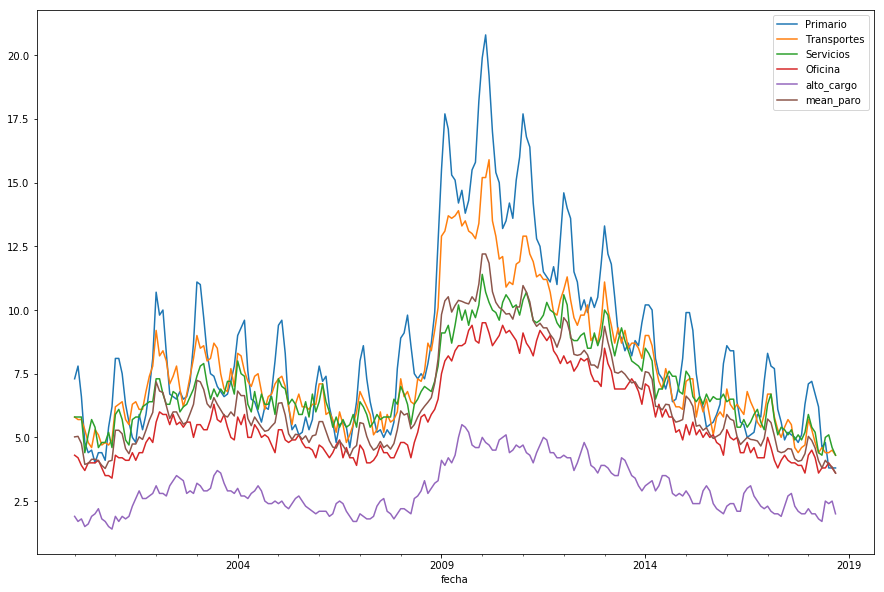

In [5]:
df1 = df[df.columns[1:7]]
df1.plot(legend= True,figsize=(15,10))

Pasemoa a analizar solo el paro del sector primario. 

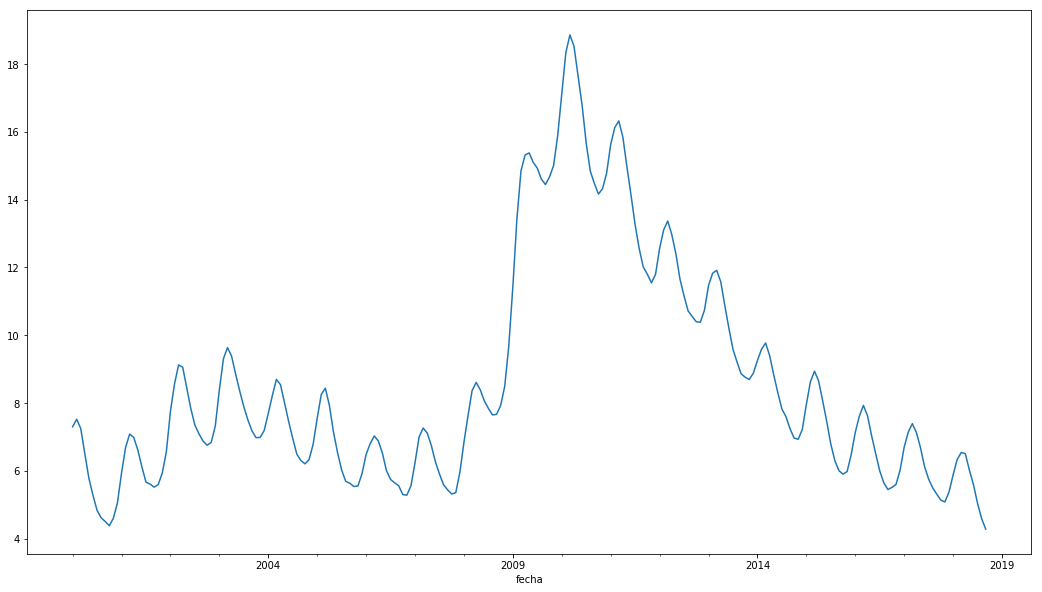

In [7]:
df.Primario=df.Primario.ewm(span=3).mean()
df.Primario.plot(figsize=(18,10))

***
Ya a simple vista podemos observar que el la tasa de paro en el sector ``Primario`` es mucho mas acusada que en el resto de los sectores, soportando subidas y bajadas mucho mas acusadas que en el resto de los sectores. 

### Aplicamos transformacion de Box- Cox

In [8]:
# Aplicamos logaritmos
df["ln_Primario"] = df.Primario.apply(math.log)
df["ln_Transportes"]= df.Transportes.apply(math.log)
df["ln_Servicios"] = df.Servicios.apply(math.log)
df["ln_Oficina"]= df.Oficina.apply(math.log)
df["ln_alto_cargo"]= df.alto_cargo.apply(math.log)
df["ln_mean_paro"]= df.mean_paro.apply(math.log)


Como podemos observar esto nos suaviza bastante las serie

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000240499C81D0>,
      dtype=object)

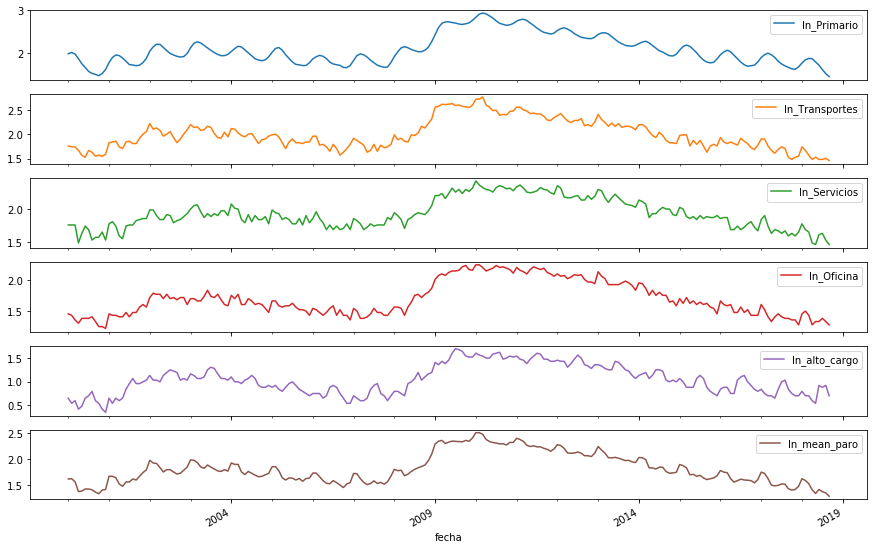

In [9]:
dfest = df[df.columns[7:]]
dfest.plot(legend= True,figsize=(15,10),subplots=True)

Esto lo podriamos interpretar como la tasa de crecimeinto de la tasa de paro segun los distintos sectores.
Podemos apreciar que se mueven de forma bastante parecidas

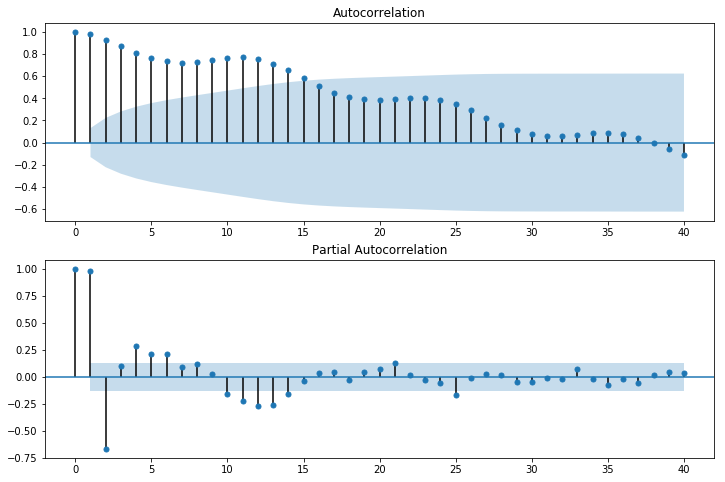

In [10]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.ln_Primario, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.ln_Primario, lags=40, ax=ax2)

In [11]:
modelo= sm.tsa.ARMA(df.ln_Primario, order=(12,0) )
arma_res = modelo.fit(disp=True)
print(arma_res.summary())

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            ln_Primario   No. Observations:                  225
Model:                    ARMA(12, 0)   Log Likelihood                 574.947
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 19 Oct 2018   AIC                          -1121.894
Time:                        17:11:41   BIC                          -1074.068
Sample:                    01-01-2000   HQIC                         -1102.591
                         - 09-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.0827      0.091     22.764      0.000       1.903       2.262
ar.L1.ln_Primario      1.8183      0.063     28.811      0.000       1.695       1.942
ar.L2.ln_Primario   

#### Este modelo es estacionario por muy poco, asi que podriamos concluir que no es estacionario.

Pero veamos como se comporta.

In [16]:
df["arma_res"]= arma_res.fittedvalues 
dffit = df[["ln_Primario","arma_res"]]

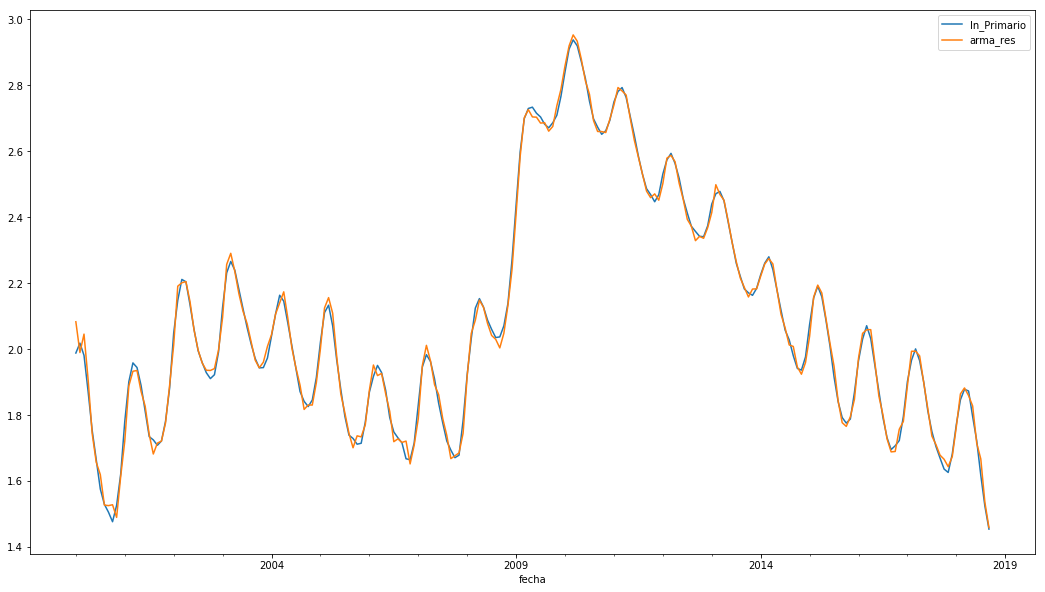

In [17]:
dffit.plot(figsize=(18,10))

In [18]:
resid = arma_res.resid

In [19]:
stats.normaltest(resid)

NormaltestResult(statistic=27.49869311598942, pvalue=1.0684019206813893e-06)

La hipotesis nula es que los residuos siguen una distribucion normal, la cual no rechazamos ya que el p-valor es mayor que 0,05.

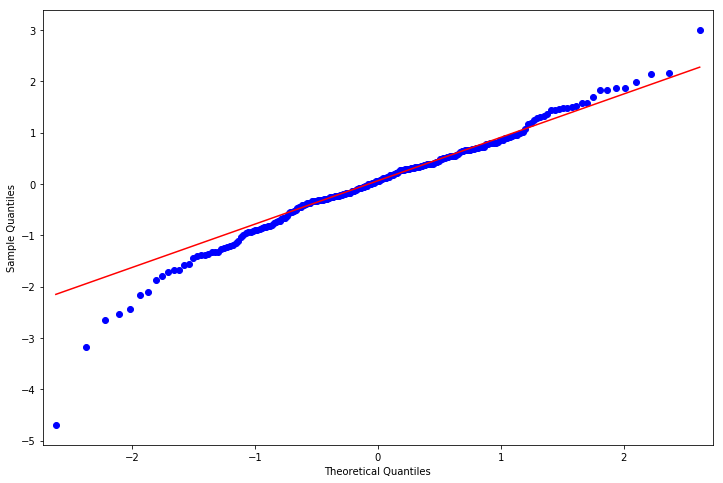

In [20]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

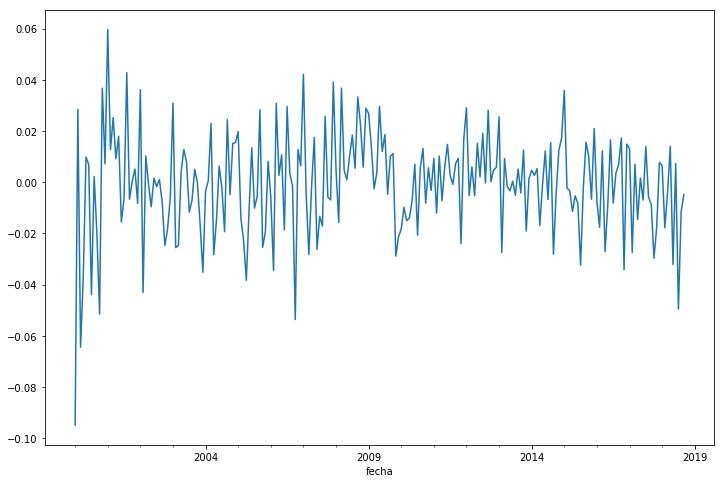

In [21]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res.resid.plot(ax=ax)

In [22]:
sm.stats.durbin_watson(arma_res.resid.values)

2.01491967626075

Representamos el correlograma de los errores

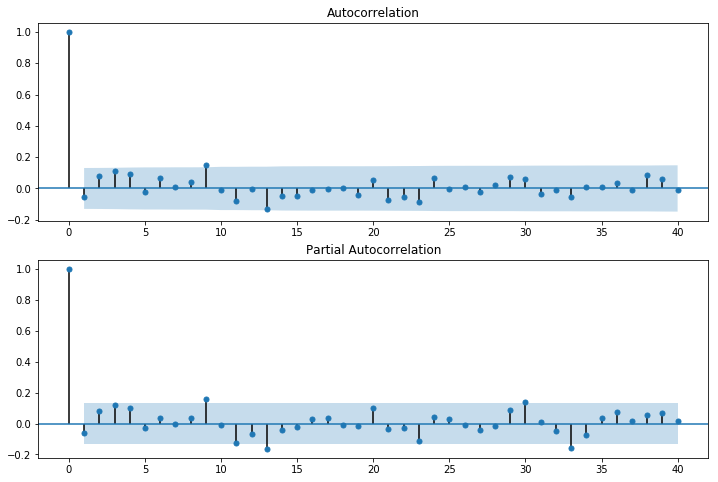

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_res.resid.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_res.resid.values, lags=40, ax=ax2)

Veamos ahora con el test de Jung - Box si se comportan como un ruido blanco.

In [50]:
tsa.acorr_ljungbox(arma_res.resid.values, lags=None, boxpierce=True)

(array([  5.52103215,   7.19726475,   7.38309152,  10.00703866,
         11.00466872,  11.08360599,  13.81600168,  22.75947816,
         23.20543485,  23.20574473,  30.06429812,  65.85536941,
         67.33209023,  68.97500537,  73.06371636,  75.61769875,
         75.70204116,  75.70207354,  75.70247298,  78.92888662,
         84.795387  ,  85.02351036,  86.1610714 , 119.01689095,
        120.68751557, 120.7855077 , 123.87685187, 129.21168598,
        129.3622236 , 129.39486596, 129.76109005, 133.21436674,
        140.56777032, 140.62055585, 144.24236748, 160.85513843,
        162.38976667, 162.4609678 , 164.83017128, 169.5830667 ]),
 array([1.87891696e-02, 2.73611166e-02, 6.06396573e-02, 4.03092834e-02,
        5.12874951e-02, 8.58266028e-02, 5.45524046e-02, 3.68717058e-03,
        5.75105909e-03, 1.00120941e-02, 1.54816805e-03, 1.89352127e-09,
        2.47770119e-09, 2.95769081e-09, 1.26427913e-09, 1.01508059e-09,
        2.20057256e-09, 4.78774000e-09, 1.01158001e-08, 5.96257293e-09

El segundo array es el que contiene los p-valores con la significación de los residuos. 
Podemos ver que los p-valores si que son mas pequeños a 0,05 por lo tanto rechazamos la hipotesis nula, los residuos no siguen un ruido blanco.

Segun el test los residuos no se acaban de comportar como un riudo blanco. Por los tanto tendriamos que reestimar el modelo

#### Pasemos a la predicción

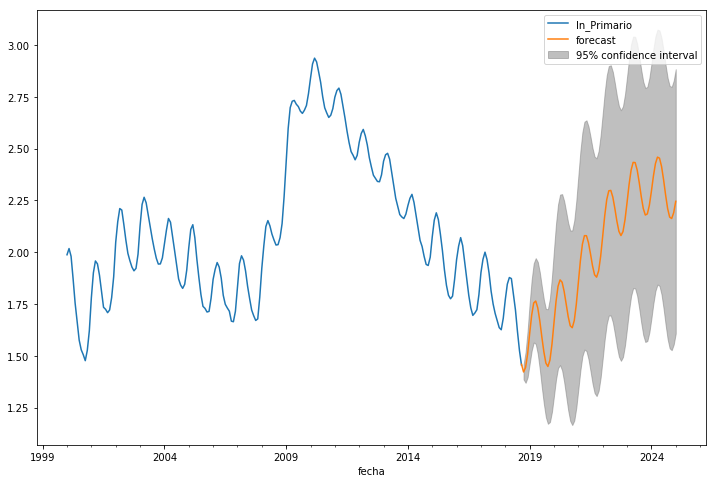

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ln_Primario.plot(ax=ax)
fig = arma_res.plot_predict('2018-09-01', '2025', dynamic=True, ax=ax, plot_insample=False)

Es normal que tengamos esta predicción teneindo encuenta que estamos tratando un ARMA(2,0) o lo que vendria siendo un autorregresivo de orden 2 por lo tanto las prediciones solo serian "fiables" para dos perodos hacia adelante. 

***


### Pasemos ahora a un modelo ARIMA 

Esto seria un procero ARMA aplicado a la difresncia $\Delta{X_t}$ esto lo podriamos interpretar a la practica como un modelo que defina la tasa de variacíon de la tasa de paro del sector primario en USA.

In [25]:
# Aplicamos proceso diferencia
df["ln_Primario_dif"] = df.ln_Primario.diff()
df = df.dropna()

In [26]:
df.head()

,fecha,Primario,Transportes,Servicios,Oficina,alto_cargo,mean_paro,ln_Primario,ln_Transportes,ln_Servicios,ln_Oficina,ln_alto_cargo,ln_mean_paro,arma_res,ln_Primario_dif
fecha,,,,,,,,,,,,,,,
2000-02-01,2000-02-01,7.522222,5.7,5.8,4.2,1.7,5.04,2.017862,1.740466,1.757858,1.435085,0.530628,1.617406,1.989437,0.029987
2000-03-01,2000-03-01,7.248299,5.7,5.8,3.9,1.8,4.76,1.980767,1.740466,1.757858,1.360977,0.587787,1.560248,2.045186,-0.037095
2000-04-01,2000-04-01,6.500762,5.3,4.4,3.7,1.5,3.94,1.871919,1.667707,1.481605,1.308333,0.405465,1.371181,1.908603,-0.108847
2000-05-01,2000-05-01,5.777788,4.8,5.1,4.0,1.6,3.98,1.754021,1.568616,1.629241,1.386294,0.470004,1.381282,1.744227,-0.117898
2000-06-01,2000-06-01,5.278715,4.6,5.7,4.0,1.9,4.14,1.663683,1.526056,1.740466,1.386294,0.641854,1.420696,1.656790,-0.090338


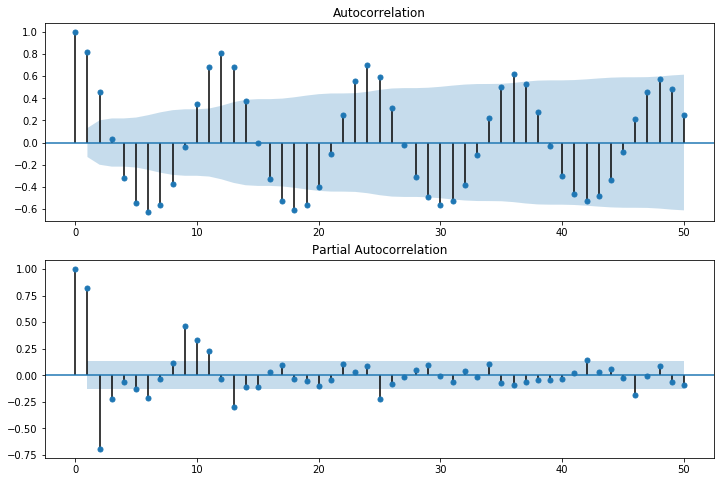

In [27]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.ln_Primario_dif, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.ln_Primario_dif, lags=50, ax=ax2)

In [28]:
modelo2= sm.tsa.ARMA(df.ln_Primario_dif, order=(10,0))
arma_res2 = modelo2.fit(disp=True)
print(arma_res2.summary())

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:        ln_Primario_dif   No. Observations:                  224
Model:                    ARMA(10, 0)   Log Likelihood                 560.889
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 19 Oct 2018   AIC                          -1097.778
Time:                        17:21:21   BIC                          -1056.838
Sample:                    02-01-2000   HQIC                         -1081.252
                         - 09-01-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0032      0.007     -0.457      0.648      -0.017       0.010
ar.L1.ln_Primario_dif      0.9589      0.062     15.501      0.000       0.838       1.080
ar.L

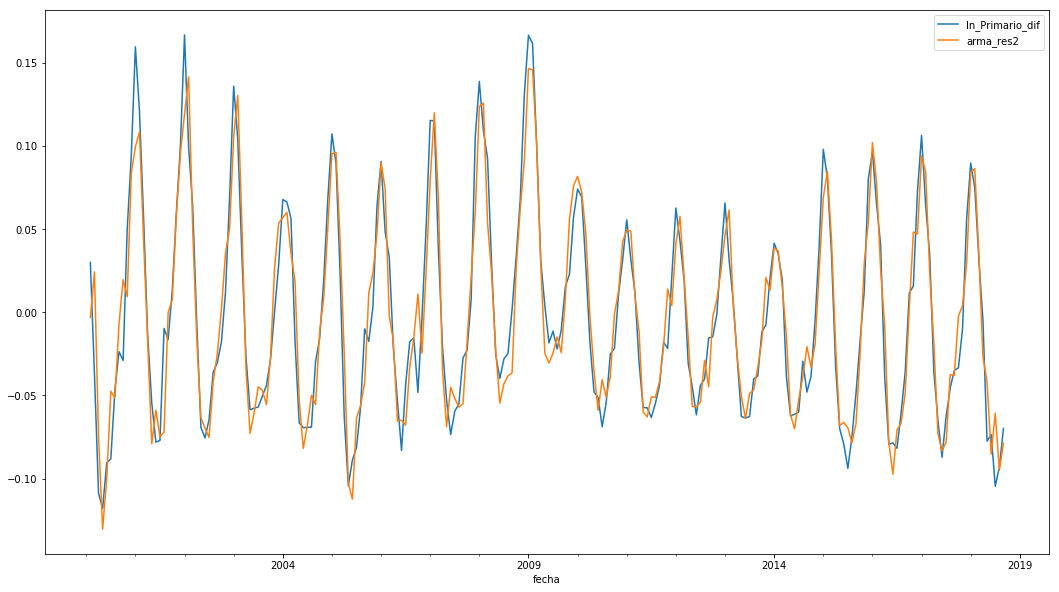

In [29]:
df["arma_res2"]= arma_res2.fittedvalues 
dffit = df[["ln_Primario_dif","arma_res2"]]
dffit.plot(figsize=(18,10))

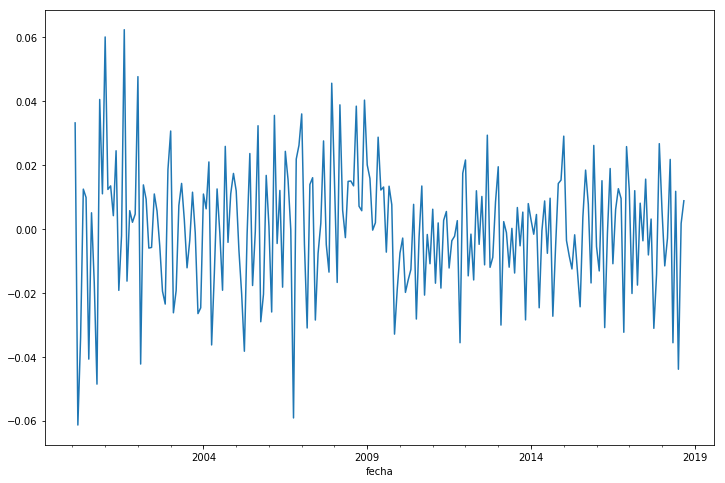

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res2.resid.plot(ax=ax)

In [31]:
resid2 = arma_res2.resid

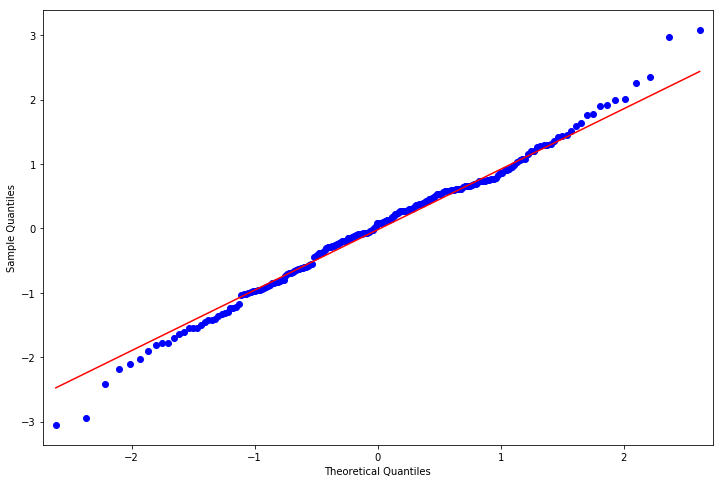

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid2, line='q', ax=ax, fit=True)

Podemos decir que los errores no tiene correlacion 

In [33]:
sm.stats.durbin_watson(arma_res2.resid.values)

2.201610318121576

In [34]:
stats.normaltest(resid2)

NormaltestResult(statistic=2.3105111523231483, pvalue=0.3149770259962291)

In [35]:
tsa.acorr_ljungbox(arma_res2.resid.values, lags=None, boxpierce=True)

(array([ 2.61173671,  5.97341659,  8.30568525, 11.52871079, 11.82193734,
        11.83516761, 11.85284508, 12.94139317, 19.66374621, 26.55630826,
        26.70918904, 31.6905743 , 33.62724979, 34.33076343, 34.44185448,
        34.5569399 , 35.04618588, 35.05878663, 35.06387595, 35.53685793,
        36.84795677, 39.58429005, 40.47473395, 44.07179658, 44.40508915,
        44.64285303, 45.23934367, 45.67064108, 46.20985646, 46.93113344,
        47.55547181, 48.06765394, 50.1272072 , 50.55537121, 50.58234505,
        51.11306598, 51.34127968, 51.38548047, 51.43318799, 51.51810266]),
 array([0.10607554, 0.05045324, 0.04009903, 0.0212226 , 0.03731081,
        0.06574867, 0.10550318, 0.11388206, 0.02010481, 0.00305981,
        0.00508324, 0.00154429, 0.00137076, 0.00184477, 0.00295073,
        0.00456751, 0.00613489, 0.00929266, 0.01372147, 0.01742446,
        0.01752326, 0.01208549, 0.01358891, 0.00748466, 0.00976683,
        0.01287825, 0.01534012, 0.01884609, 0.02236191, 0.02527149,
      

Segun el test se comporta como un ruido blanco 

### Pasemos ahora a la predicción

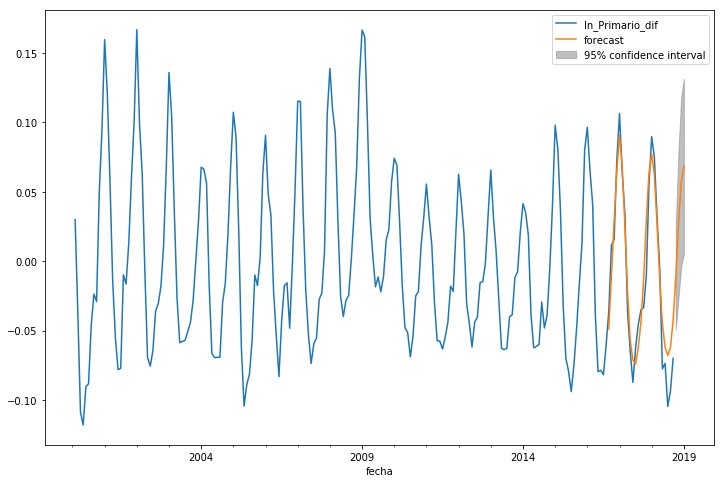

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ln_Primario_dif.plot(ax=ax)
fig = arma_res2.plot_predict('2016-09-01', '2019', dynamic=True, ax=ax, plot_insample=False)

## Filtro Hodrick y Prescott

El filtro HP es uno delos más usados en economia para el analisis del PIB, separando la tendencia del ciclo de forma que:$$y_t\ = \tau_t\ + c_t\ + \epsilon_t\,$$
El filtro HP funciona segun la minimizacion de la siguente función cuadratica:
<math>$$\min_{\tau}\left(\sum_{t = 1}^T {(y_t - \tau _t )^2 }  + \lambda \sum_{t = 2}^{T - 1} {[(\tau _{t+1}  - \tau _t) - (\tau _t  - \tau _{t - 1} )]^2 }\right).\,$$</math>

Para ajustar la sensibilidad del filtro se hace mrdiante el ajuste del parameto $\lambda$ que para nuestro caso, el de una serie mensual se ajustaria a 1400. 

In [51]:
df["ln_Primario_fil"] = df.Primario.apply(math.log)
cycle, trend = sm.tsa.filters.hpfilter(df.ln_Primario_fil, 14400)

In [52]:
df["ciclo"]= cycle
df["tendencia"]=trend

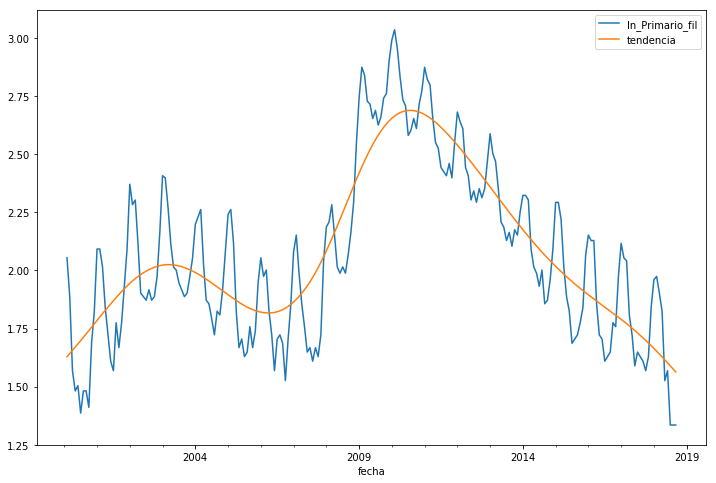

In [54]:
df[["ln_Primario_fil","tendencia"]].plot(figsize=(12,8))                                     


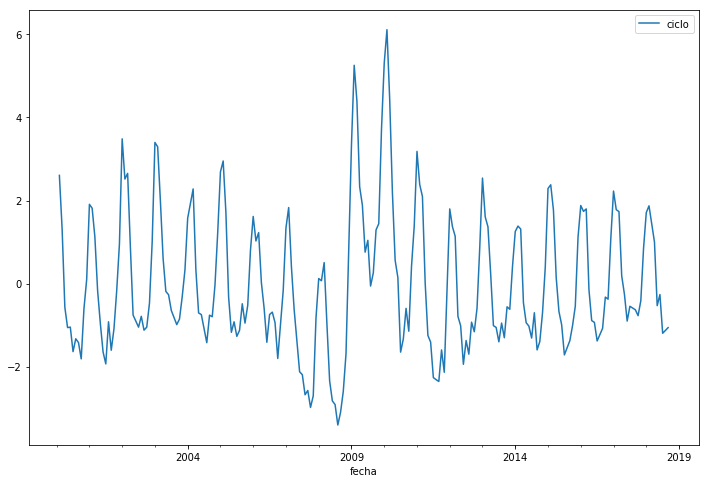

In [37]:
df[["ciclo"]].plot(figsize=(12,8)) 

Apartir de esta división podriamos pasar a estudiar la parte ciclica del paro, pero esto sera en otro notebook.